In [1]:
import os
import tqdm 
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# Define transformations (normalize pixel values to [-1, 1])
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    # transforms.Normalize((0.5,), (0.5,))  # Normalize with mean=0.5 and std=0.5
])

# Download and load the training and test datasets
train_dataset = datasets.MNIST(
    root='./data',  # Directory to save the dataset
    train=True,     # Load the training set
    transform=transform,
    download=True   # Download the dataset if not already available
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,    # Load the test set
    transform=transform,
    download=True
)

# Data loaders for batch processing
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,  # Batch size
    shuffle=True    # Shuffle the data for training
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False   # No need to shuffle for testing
)

In [3]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder network
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            # nn.Conv2d(128, 1, kernel_size=4, stride=2, padding=1), 
            # nn.ReLU(),
            nn.Flatten(),
        )
        
        self.fc_mu = nn.Linear(27, 2)
        self.fc_logvar = nn.Linear(27, 2)

        # Decoder network88
        self.fc_decode = nn.Linear(2, 27)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (3, 3, 3)),
            nn.ConvTranspose2d(3, 128, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=0),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),    
            # nn.ReLU(),
            # nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     
            nn.Sigmoid(),
        )

    def encode(self, x):
        h1 = self.encoder(x)
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Convert logvar to standard deviation (std)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = self.fc_decode(z)
        x_reconstructed = self.decoder(h3)
        return x_reconstructed

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar

def loss_function(reconstructed_x, x, mu, logvar):
    # Binary Cross-Entropy (BCE) loss for reconstruction + KL divergence loss
    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    # MSE = F.mse_loss(input=reconstructed_x, target=x, reduction='sum')
    # KL Divergence losssum
    # Equation for KL divergence between normal distribution and learned distribution
    # D_KL = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # where sigma is exp(logvar / 2)
    # We are working with the N(0,1) as the prior
    # This loss is summed over all pixels in the image
    KL_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KL_divergence

In [4]:
vae = VAE().to(device)
vae.load_state_dict(torch.load('models_mnist/best_model_19_t_9542.1279296875_v_9537.3115234375.pt')['state_dict'])
vae.eval();

/tmp/ipykernel_24310/63765536.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load('models_mnist/best_model_19_t_9542.1279296875_v_9537.3115234

In [5]:
Z_loss, Z_E_loss = [], []


for imgs, _ in tqdm.tqdm(train_loader):
    imgs = imgs.to(device)
    with torch.no_grad():
        mu, logvar = vae.encode(imgs)
        std = torch.exp(0.5 * logvar)
        z = mu + std
        z_e = mu + std * torch.randn_like(std)

        imgs = imgs.permute(0, 2, 3, 1).cpu()
        reconstructed_imgs_e = vae.decode(z_e)
        reconstructed_imgs_e = reconstructed_imgs_e.permute(0, 2, 3, 1).cpu()

        reconstructed_imgs = vae.decode(z)
        reconstructed_imgs = reconstructed_imgs.permute(0, 2, 3, 1).cpu()

        z_loss = F.binary_cross_entropy(reconstructed_imgs, imgs)
        z_e_loss = F.binary_cross_entropy(reconstructed_imgs_e, imgs)
        
        Z_loss.append(z_loss.item())
        Z_E_loss.append(z_e_loss.item())
    

100%|██████████| 938/938 [00:09<00:00, 102.32it/s]


In [6]:
print(f"Mean BCE loss for Z: {np.mean(Z_loss):.5f} and Z_E: {np.mean(Z_E_loss):.5f}\nMedian BCE loss for Z: {np.median(Z_loss):.5f} and Z_E: {np.median(Z_E_loss):.5f}")

Mean BCE loss for Z: 0.18155 and Z_E: 0.18171
Median BCE loss for Z: 0.18141 and Z_E: 0.18160


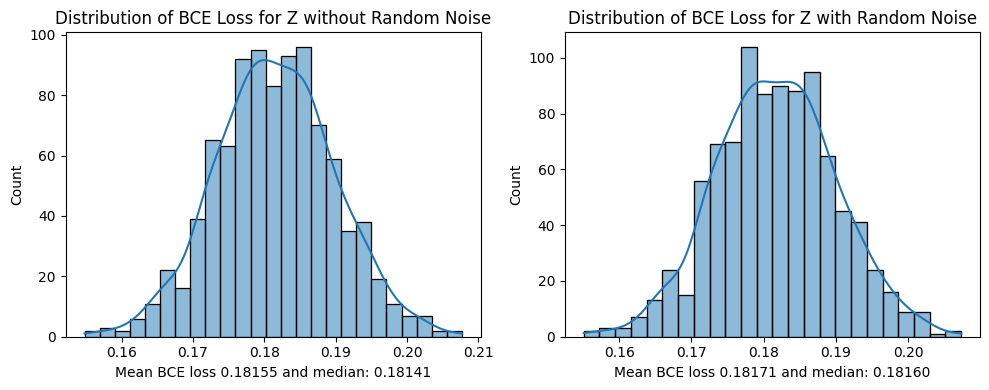

In [7]:
# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# First plot: Distribution without random noise
sns.histplot(Z_loss, ax=axes[0], kde=True)  # Use histplot for better subplot control
axes[0].set_title("Distribution of BCE Loss for Z without Random Noise")
axes[0].set_xlabel(f"Mean BCE loss {np.mean(Z_loss):.5f} and median: {np.median(Z_loss):.5f}")

# Second plot: Distribution with random noise
sns.histplot(Z_E_loss, ax=axes[1], kde=True)
axes[1].set_title("Distribution of BCE Loss for Z with Random Noise")
axes[1].set_xlabel(f"Mean BCE loss {np.mean(Z_E_loss):.5f} and median: {np.median(Z_E_loss):.5f}")

# Adjust layout
plt.tight_layout()
plt.show()

In [8]:
Z = []

for imgs, labels in tqdm.tqdm(train_loader):
    imgs = imgs.to(device)
    with torch.no_grad():
        mu, logvar = vae.encode(imgs)
        std = torch.exp(0.5 * logvar)
        z = mu + std
        # z = z.cpu()
        X1, X2 = z[:, 0], z[:, 1]
        for x1, x2, label in zip(X1, X2, labels):
            Z.append((x1.item(), x2.item(), label.item()))

100%|██████████| 938/938 [00:07<00:00, 129.70it/s]


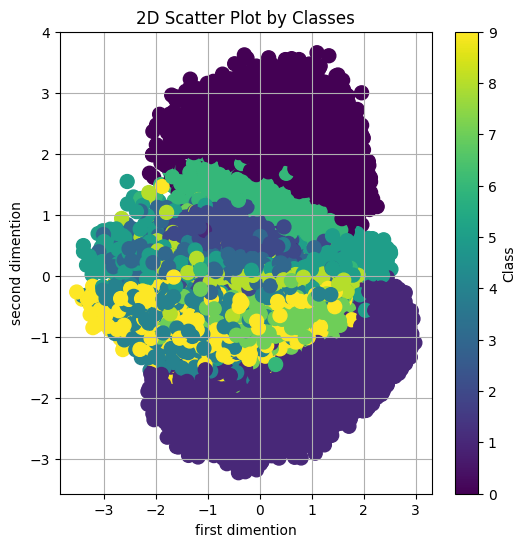

In [9]:
x = [item[0] for item in Z]
y = [item[1] for item in Z]
classes = [item[2] for item in Z]

# Create scatter plot
plt.figure(figsize=(6, 6))
scatter = plt.scatter(x, y, c=classes, cmap='viridis', s=100, alpha=1)
plt.colorbar(scatter, label="Class") 
plt.title("2D Scatter Plot by Classes")
plt.xlabel("first dimention")
plt.ylabel("second dimention")
plt.grid(True)
plt.show()

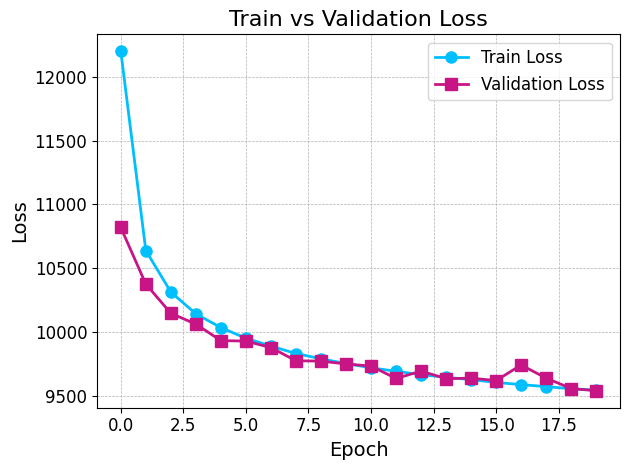

In [85]:
df = pd.read_csv('mnist_vae_loss.csv')

plt.plot(df.epoch, df.train_loss, label="Train Loss", color='deepskyblue', marker='o', markersize=8, linestyle='-', linewidth=2)
plt.plot(df.epoch, df.val_loss, label="Validation Loss", color='mediumvioletred', marker='s', markersize=8, linestyle='-', linewidth=2)

plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Train vs Validation Loss", fontsize=16)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# unique_classes = set(classes)
# markers = ['o', 's', 'D', '^', 'P', '*', 'X', 'v', 'h', '<']
# plt.figure(figsize=(6, 6))

# for x1, x2, cls in tqdm.tqdm(Z):
#     plt.scatter(x1, x2, label=f"Class {cls}", marker=markers[cls], alpha=0.8)

# plt.title("2D Scatter Plot by Classes with Separate Markers")
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.legend()
# plt.grid(True)
# plt.show()

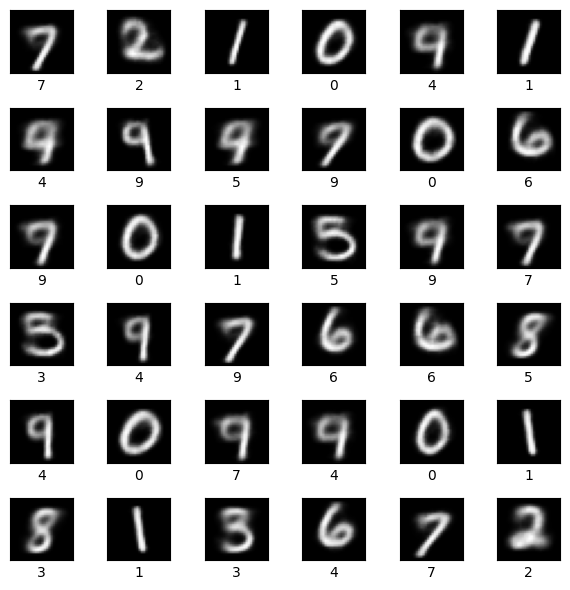

In [40]:
imgs, labels = next(iter(test_loader))

with torch.no_grad():
    reconstructed_imgs = vae(imgs.cuda())[0].permute(0, 2, 3, 1).cpu()

fig, axes = plt.subplots(6, 6, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(reconstructed_imgs[i], cmap="gray")
    ax.set_xlabel(labels[i].item())
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(hspace=1, wspace=1)
plt.tight_layout()
plt.show()

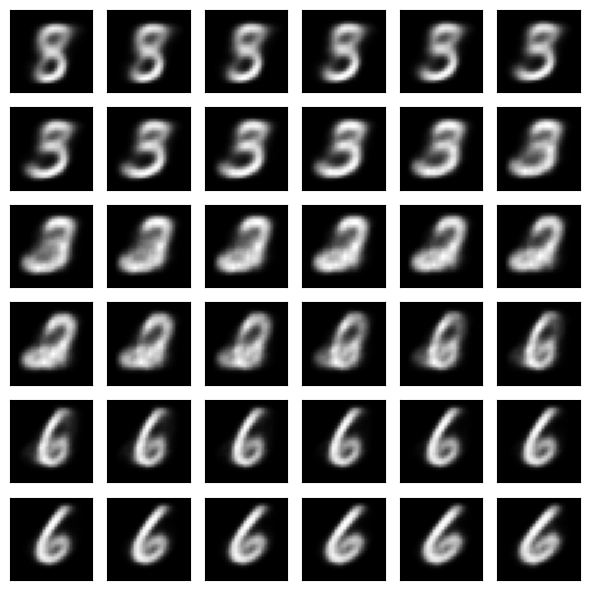

In [63]:
start_vector = np.array([0, 0])
target_vector = np.array([1, 1])

steps = 36

# Generate the vectors
vectors = []
for i in range(steps):
    # Linear interpolation
    alpha = i / (steps - 1)
    interpolated_vector = (1 - alpha) * start_vector + alpha * target_vector
    vectors.append(interpolated_vector)

vectors = torch.tensor(vectors, dtype=torch.float32).cuda()

with torch.no_grad():
    reconstructed_imgs = vae.decode(vectors).permute(0, 2, 3, 1).cpu()

fig, axes = plt.subplots(6, 6, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(reconstructed_imgs[i], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(hspace=1, wspace=1)
plt.tight_layout()
plt.show()

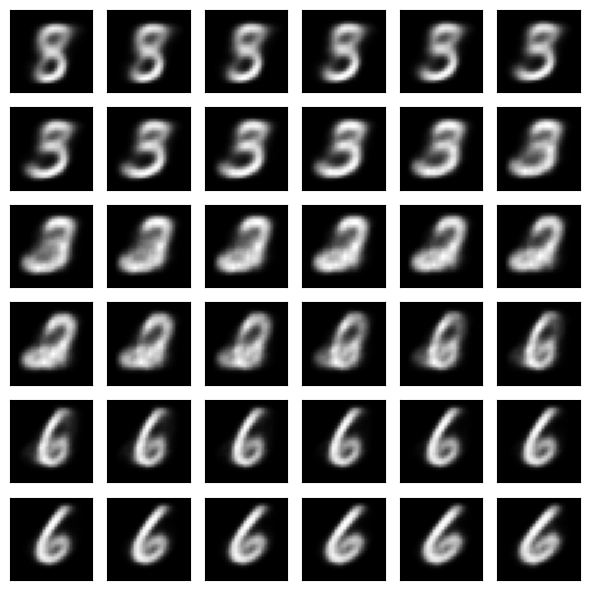

In [83]:
n = 36
grid_x = torch.linspace(-6, 6, n)
grid_y = torch.linspace(-6, 6, n).flip(dims=[0])
combined = torch.stack((grid_x, grid_y), dim=1)

with torch.no_grad():
    reconstructed_imgs = vae.decode(vectors).permute(0, 2, 3, 1).cpu()

fig, axes = plt.subplots(6, 6, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(reconstructed_imgs[i], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(hspace=1, wspace=1)
plt.tight_layout()
plt.show()